# 物体検出（SSD）

In [1]:
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 MB 10.2 MB/s eta 0:00:0000:0100:01


In [2]:
import os.path as osp
import random
import xml.etree.ElementTree as ET

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data

%matplotlib inline


In [3]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)


In [6]:
def make_datapath_list(rootpath):
    imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')
    annopath_template = osp.join(rootpath, 'Annotations', '%s.xml')
    
    train_id_names = osp.join(rootpath + 'ImageSets/Main/train.txt')
    val_id_names = osp.join(rootpath + 'ImageSets/Main/val.txt')
    
    train_img_list = list()
    train_anno_list = list()
    
    for line in open(train_id_names):
        file_id = line.strip()
        img_path = (imgpath_template % file_id)
        anno_path = (annopath_template % file_id)
        train_img_list.append(img_path)
        train_anno_list.append(anno_path)
        
    val_img_list = list()
    val_anno_list = list()
    
    for line in open(val_id_names):
        file_id = line.strip()
        img_path = (imgpath_template % file_id)
        anno_path = (annopath_template % file_id)
        val_img_list.append(img_path)
        val_anno_list.append(anno_path)
        
    return train_img_list, train_anno_list, val_img_list, val_anno_list


In [7]:
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath)

print(train_img_list[0])


./data/VOCdevkit/VOC2012/JPEGImages/2008_000008.jpg


In [8]:
class Anno_xml2list(object):
    def __init__(self, classes):
        self.classes = classes
        
    def __call__(self, xml_path, width, height):
        ret = []
        
        xml = ET.parse(xml_path).getroot()
        
        for obj in xml.iter('object'):
            difficult = int(obj.find('difficult').text)
            if difficult == 1:
                continue
                
            bndbox = []
            
            name = obj.find('name').text.lower().strip()
            bbox = obj.find('bndbox')
            
            pts = ['xmin', 'ymin', 'xmax', 'ymax']
            
            for pt in (pts):
                cur_pixel = int(bbox.find(pt).text) - 1
                
                if pt == 'xmin' or pt == 'xmax':
                    cur_pixel /= width
                else:
                    cur_pixel /= height
                    
                bndbox.append(cur_pixel)
                
            label_idx = self.classes.index(name)
            bndbox.append(label_idx)
            
            ret += [bndbox]
            
        return np.array(ret)
    

In [9]:
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

transform_anno = Anno_xml2list(voc_classes)

ind = 1
image_file_path = val_img_list[ind]
img = cv2.imread(image_file_path)
height, width, channels = img.shape

transform_anno(val_anno_list[ind], width, height)


array([[ 0.09      ,  0.03003003,  0.998     ,  0.996997  , 18.        ],
       [ 0.122     ,  0.56756757,  0.164     ,  0.72672673, 14.        ]])

## 画像とアノテーションの前処理クラス

In [12]:
from utils.data_augumentation import Compose, ConvertFromInts, ToAbsoluteCoords, PhotometricDistort, Expand, RandomSampleCrop, RandomMirror, ToPercentCoords, Resize, SubtractMeans


class DataTransform():
    def __init__(self, input_size, color_mean):
        self.data_transform = {
            'train': Compose([
                ConvertFromInts(),
                ToAbsoluteCoords(),
                PhotometricDistort(),
                Expand(color_mean),
                RandomSampleCrop(),
                RandomMirror(),
                ToPercentCoords(),
                Resize(input_size),
                SubtractMeans(color_mean)
            ]),
            'val': Compose([
                ConvertFromInts(),
                Resize(input_size),
                SubtractMeans(color_mean)
            ])
        }
        
    def __call__(self, img, phase, boxes, labels):
        return self.data_transform[phase](img, boxes, labels)
        

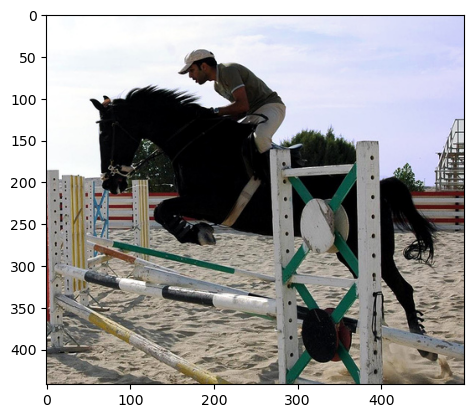

/Users/yabukita_shou/Desktop/dev/pytorch_test/2_SSD/utils/data_augumentation.py:246: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


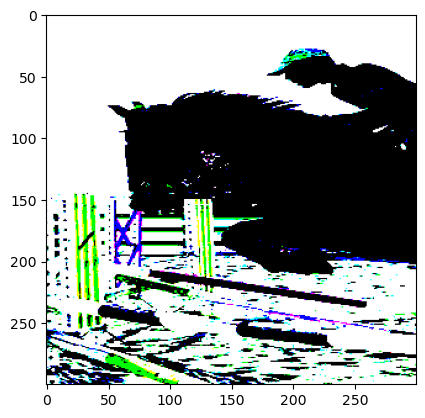

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


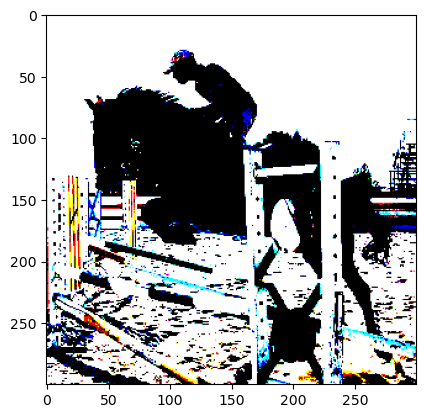

In [13]:
image_file_path = train_img_list[0]
img = cv2.imread(image_file_path)
height, width, channels = img.shape

transform_anno = Anno_xml2list(voc_classes)
anno_list = transform_anno(train_anno_list[0], width, height)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

color_mean = (104, 117, 123)
input_size = 300
transform = DataTransform(input_size, color_mean)

phase = 'train'
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

phase = 'val'
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()


## Datasetの作成

In [14]:
class VOCDataset(data.Dataset):
    def __init__(self, img_list, anno_list, phase, transform, transform_anno):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase
        self.transform = transform
        self.transform_anno = transform_anno
    
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, index):
        im, gt, h, w = self.pull_item(index)
        return im, gt
    
    def pull_item(self, index):
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)
        height, width, channels = img.shape
        
        anno_file_path = self.anno_list[index]
        anno_list = self.transform_anno(anno_file_path, width, height)
        
        img, boxes, labels = self.transform(
            img, self.phase, anno_list[:, :4], anno_list[:, 4])
        
        img = torch.from_numpy(img[:, :, (2, 1, 0)]).permute(2, 0, 1)
        
        gt = np.hstack((boxes, np.expand_dims(labels, axis=1)))
        
        return img, gt, height, width
    

In [17]:
color_mean = (104, 117, 123)
input_size = 300

train_dataset = VOCDataset(train_img_list, train_anno_list, phase='train', transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase='val', transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))

val_dataset.__getitem__(1)


(tensor([[[   0.9417,    6.1650,   11.1283,  ...,  -22.9083,  -13.2200,
             -9.4033],
          [   6.4367,    9.6600,   13.8283,  ...,  -21.4433,  -18.6500,
            -18.2033],
          [  10.8833,   13.5500,   16.7000,  ...,  -20.9917,  -24.5250,
            -25.1917],
          ...,
          [ -23.9500,  -14.9000,   -1.7583,  ..., -108.6083, -111.0000,
           -117.8083],
          [ -28.2817,  -20.1750,   -5.5633,  ..., -104.9933, -111.8350,
           -119.0000],
          [ -20.4767,  -21.0000,  -12.6333,  ..., -107.1683, -115.7800,
           -117.1100]],
 
         [[  25.9417,   30.1650,   35.1283,  ...,  -18.0767,  -14.7250,
            -11.8533],
          [  31.4367,   33.6600,   37.8283,  ...,  -13.5017,  -10.8250,
            -10.3783],
          [  35.7917,   37.5500,   40.7000,  ...,  -11.8417,  -13.0750,
            -14.0167],
          ...,
          [  -1.9500,    7.1000,   20.2417,  ..., -101.9083, -102.0000,
           -109.7167],
          [  -6.2

In [18]:
def od_collate_fn(batch):
    targets = []
    imgs = []
    for sample in batch:
        imgs.append(sample[0])
        targets.append(torch.FloatTensor(sample[1]))
        
    imgs = torch.stack(imgs, dim=0)
    
    return imgs, targets


In [19]:
batch_size = 4

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=od_collate_fn)

dataloaders_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator = iter(dataloaders_dict['val'])
images, targets = next(batch_iterator)
print(images.size())
print(len(targets))
print(targets[1].size())


torch.Size([4, 3, 300, 300])
4
torch.Size([2, 5])


In [20]:
print(train_dataset.__len__())
print(val_dataset.__len__())


5717
5823
